# PyTorch Workflow


In [1]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "makiing predictions and evaluating a model (inference)",
    5: "putting it all together",
}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'makiing predictions and evaluating a model (inference)',
 5: 'putting it all together'}

In [2]:
import torch
from torch import nn  # All building blocks for neural network
import matplotlib.pyplot as plt

# PyTorch version
torch.__version__

'2.0.0.post302'

## 1. Data (preparing and loading)

Data can be almost anything .. in machine learning

- Excel
- Images
- Videos
- Audio
- DNA
- Text

Machine learning is a game of two parts:
1. Get data into a numerical represntation
2. Build a model to learn patters in the numerical representation

To showcase this, let's create some *known* data using linear regression formula

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Creat
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets  (one of the most important concepts in machine learning in general)

In [5]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Visualize the data

In [6]:
def plot_prediction(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    """
    Plots training data, test data and compares predictions/
    """
    plt.figure(figsize=(7, 4))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

    # Plot predictions
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

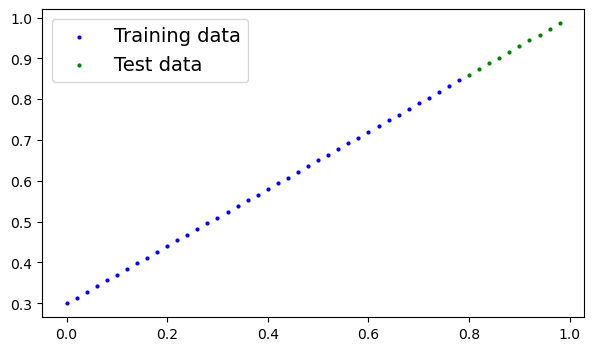

In [7]:
plot_prediction()

## 2. Build a model

What our model does:
- start with random values (weight and bias)
- Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and bias we used to create the data).

How does it do so?
1.  Gradient descent
2.  Backpropagation


In [8]:
# Create lienar regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float)
        )
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:  # "x" is the input data
        return self.weights * x + self.bias

### PyTorch model building essentials

- torch.nn - contains all building blocks for computational graphs
- torch.nn.Parameter - what parameters should our model try and layer
- torch.nn.Module - Base class for all neural netowrk modules. need to overwrite forward()
- torch.optim - this is where the optimizers in PyTorch live, will helpn with gradient descent

### Checking the contents of our model

In [9]:
# Create manual seed
torch.manual_seed(42)
# Initialize model_0 instance of LinearRegressionModel
model_0 = LinearRegressionModel()
# Check parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's prediction and how well it predicts.



In [11]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

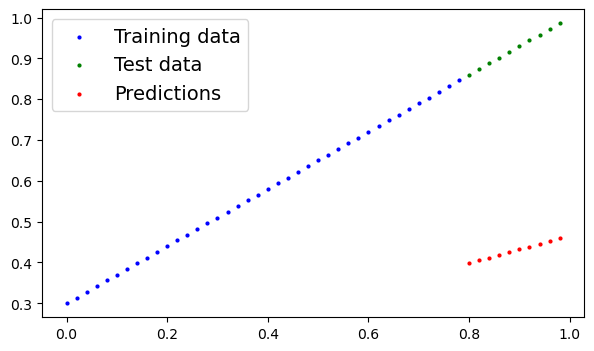

In [12]:
plot_prediction(predictions=y_preds)

## 3. Train model

Training is for a model to move from some *known* parameters to some known parameters

poor -> good representation

Loss function - gauge how wrong your models predictions are

Things we need to train:
1. Loss function: measure of how wrong the model is.
2. Optimizer: uses loss and adjusts the model's parameters

In [13]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

0. Loop through the data
1. forward pass (this involves data moving through our mode's `forward`) - aka forward propagation
2. Calculate the loss (compare forward pass prediction to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through
5. Optimizer step - use the optimizer to adjust our model's parameters

In [14]:
torch.manual_seed(42)

epochs = 100
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
    model_0.train()  # Train mode in PyTorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    # by default how the optimizer changes will accumulate through the loop so ...
    # we have to zero them in step 3.
    optimizer.step()

    # Testing
    model_0.eval()  # Turns off gradient tracking
    with torch.inference_mode():
        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # Print out model state_dict()
    if epoch % 10 == 0 or epoch == epochs - 1:
        epoch_count.append(epoch)
        loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch:>4} | Test: {loss} | Test loss: {test_loss}")

Epoch:    0 | Test: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch:   10 | Test: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch:   20 | Test: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch:   30 | Test: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch:   40 | Test: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch:   50 | Test: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch:   60 | Test: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch:   70 | Test: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch:   80 | Test: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch:   90 | Test: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch:   99 | Test: 0.02479521557688713 | Test loss: 0.05687814950942993


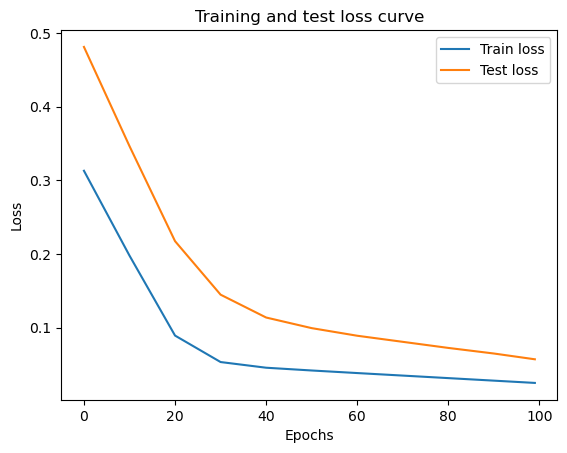

In [15]:
# Plot the loss curve
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [16]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)
    loss = loss_fn(y_preds_new, y_test)
    print("Test Loss: ", loss)

Test Loss:  tensor(0.0569)


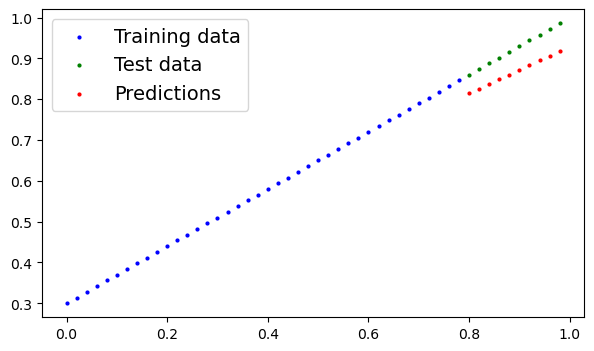

In [17]:
plot_prediction(predictions=y_preds_new)

## Saving a model in PyTorch

THere are three main methods you should know about for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Pythons pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict() - this allows you to load a models' saved state dictionary

In [18]:
# Saving our pytorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create  a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model to statedict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model
since we saved our model's state_dict rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict` into that

In [19]:
# Initialize model class instance
loaded_model_0 = LinearRegressionModel()

# Load the state dict|
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [20]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

In [21]:
model_0.eval()
with torch.inference_mode():
    model_preds = model_0(X_test)

model_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

In [22]:
model_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

Create device agnostic code

meaing, use gpu if available and cpu if not

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [24]:
!nvidia-smi

Wed Jun 26 20:26:48 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.01    Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8    14W /  N/A |   1481MiB /  6144MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Putting it all together



### 6.1 Data

In [25]:
# Create some data using linear regression formula y = weight * X + bias
weight = 0.7
bias = 0.3

# Create a range of values
start = 0
end = 1
step = 0.02

# Create X and y (feature, labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [26]:
# split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

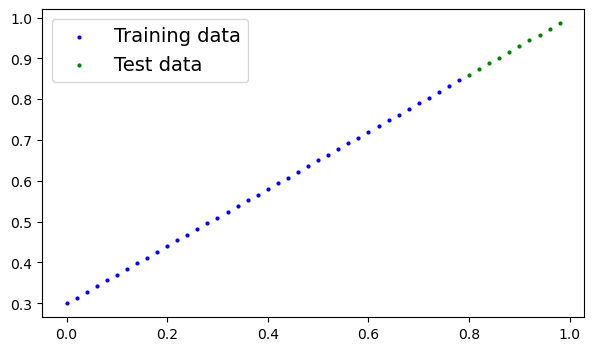

In [27]:
# Plot the data
plot_prediction(X_train, y_train, X_test, y_test)

### 6.2 Build a linear model

In [28]:
## Create a linear model by subclassing nn.module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear for creating model parameters
        # Returns a function (of mx+b) with initialized weight and bias
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


## Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [29]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [30]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For the training we need:
- Loss function
- Optimizer
- Training loop
- Testing loop

In [31]:
# Setup loss function
loss_fn = nn.L1Loss()  # Same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [32]:
# Training loop

torch.manual_seed(42)

# Put data on target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


epochs = 200
for epoch in range(epochs):
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### TESTING
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)

        test_loss = loss_fn(test_pred, y_test)

    ### PRINT OUT
    if epoch % 10 == 0:
        print(f"epoch: {epoch:3}  |  Loss: {loss:.8f}  |  Test loss: {test_loss:.8f}")

epoch:   0  |  Loss: 0.55517799  |  Test loss: 0.57397622
epoch:  10  |  Loss: 0.43996808  |  Test loss: 0.43926641
epoch:  20  |  Loss: 0.32475820  |  Test loss: 0.30455658
epoch:  30  |  Loss: 0.20954834  |  Test loss: 0.16984670
epoch:  40  |  Loss: 0.09433845  |  Test loss: 0.03513690
epoch:  50  |  Loss: 0.02388639  |  Test loss: 0.04784907
epoch:  60  |  Loss: 0.01995680  |  Test loss: 0.04580312
epoch:  70  |  Loss: 0.01651799  |  Test loss: 0.03753057
epoch:  80  |  Loss: 0.01308917  |  Test loss: 0.02994491
epoch:  90  |  Loss: 0.00965318  |  Test loss: 0.02167237
epoch: 100  |  Loss: 0.00621568  |  Test loss: 0.01408671
epoch: 110  |  Loss: 0.00278724  |  Test loss: 0.00581416
epoch: 120  |  Loss: 0.00126450  |  Test loss: 0.01380180
epoch: 130  |  Loss: 0.00126450  |  Test loss: 0.01380180
epoch: 140  |  Loss: 0.00126450  |  Test loss: 0.01380180
epoch: 150  |  Loss: 0.00126450  |  Test loss: 0.01380180
epoch: 160  |  Loss: 0.00126450  |  Test loss: 0.01380180
epoch: 170  | 

In [33]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [34]:
 weight, bias

(0.7, 0.3)

### 6.4 Making and evaluationg predictions

In [35]:
# Turn on eval mode
model_1.eval()


# Make prediction on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

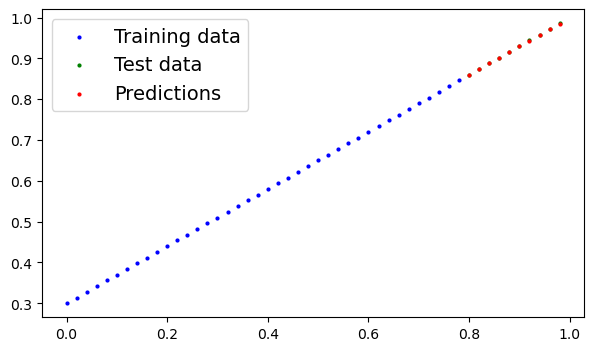

In [36]:
# Check out our model predictions visually
plot_prediction(predictions=y_preds.to("cpu"))

### 6.5 Saving and loading model 1

In [37]:
### SAVING MODEL

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create  a model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model to statedict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [38]:
### LOADING MODEL

# Initialize model class instance
loaded_model_1 = LinearRegressionModelV2()

# Load the state dict|
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [39]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [40]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [41]:
### MAKE PREDICTIONS WITH LOADED MODEL
loaded_model_1.eval()


# Make prediction on the test data
with torch.inference_mode():
    loaded_model_1_y_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

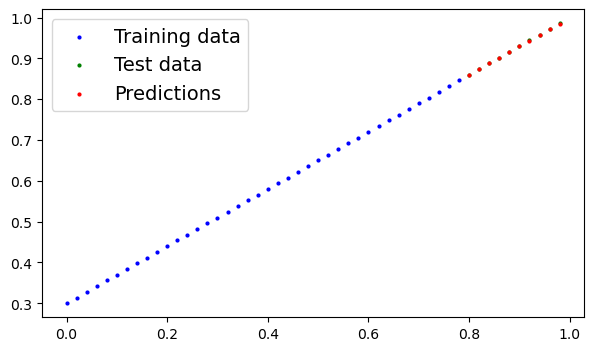

In [42]:
plot_prediction(predictions=y_preds.to("cpu"))